In [1]:
using Plots
using Statistics
using Surrogates
using CSV
using DataFrames
using Distributions
using Flux
import JSON
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

include("../../scan_hyperparameters_withcellnum_functions.jl")

main (generic function with 1 method)

### Loading data and making cuts for proper scaling

In [64]:
target_directory = "../../data/full_with_cellnumber/"

println("Formatting data...")
x_raw_df, y_df, cellnumber_df = getrawdata_withcellnum(target_directory)

# how to process cellnumber, for now let's make it another dvar
x_raw_origcn_df = hcat(x_raw_df, cellnumber_df)
x_raw_df = hcat(x_raw_df, cellnumber_df .% 2)

# cutting
println("Cutting Transmission to 60-100 percent...")
lower::Float32 = 60
upper::Float32 = 120
x_raw_df, y_df = applycut(x_raw_df, y_df, "OBJ1", lower, upper; with_numcells=true)

# decorrelating
println("Decorrelating...")
x_df = decorrelatedvars(x_raw_df; with_numcells=true)

x_scaled_df, x_scalers = minmaxscaledf(x_df);
y_scaled_df, y_scalers = minmaxscaledf(y_df);

println("Done!")

Formatting data...
Cutting Transmission to 60-100 percent...
x_raw shape: (217293, 15)
y_raw shape: (217293, 6)
x_new shape: (161574, 15)
y_new shape: (161574, 6)
Decorrelating...
Done!


A sanity check since Julia alphabetizes column names:

Recall that these are the original ranges of our DVARs

```
DVAR1: Bmax  [ 8.5, 12.0 ]
DVAR2: mX1  [ 5, 140 ]
DVAR3: mX2  [ 15, 160 ]
DVAR4: mY1  [ 1.005, 1.7 ]
DVAR5: mY2  [ 1.055, 1.85 ]
DVAR6: mtau1  [ 1, 500 ]
DVAR7: mtau2  [ 1, 500 ]
DVAR8: PhiY1  [ -89.95, -30 ]
DVAR9: PhiY2  [ -87.45, -25 ]
DVAR10: Phitau1  [ 1, 500 ]
DVAR11: Phitau2  [ 1, 500 ]
DVAR12: mY3ref  [ 1.105, 2.0 ]
DVAR13: PhiY3ref  [ -84.95, -20 ]
DVAR14: Eref  [ 0.055, 0.075 ]
```

but recall also that we decorrelate `DVAR3`, `DVAR5`, `DVAR9`, `DVAR12`, `DVAR13`. This means that their unscaled values will fall between 0 and 1.

In [65]:
x_scalers # looks good

Dict{String, MinMaxScaler} with 15 entries:
  "DVAR7"      => MinMaxScaler(1.00229, 499.997)
  "DVAR5"      => MinMaxScaler(-7.45177f-8, 0.999996)
  "DVAR12"     => MinMaxScaler(7.62605f-6, 0.999995)
  "DVAR14"     => MinMaxScaler(0.0550001, 0.075)
  "DVAR2"      => MinMaxScaler(5.00044, 139.998)
  "DVAR10"     => MinMaxScaler(1.00164, 499.998)
  "DVAR1"      => MinMaxScaler(8.50003, 12.0)
  "DVAR3"      => MinMaxScaler(1.07697f-5, 0.999994)
  "DVAR6"      => MinMaxScaler(1.00127, 499.998)
  "DVAR4"      => MinMaxScaler(1.00501, 1.7)
  "DVAR8"      => MinMaxScaler(-89.95, -30.0006)
  "DVAR13"     => MinMaxScaler(2.18249f-5, 0.999996)
  "cellnumber" => MinMaxScaler(0.0, 1.0)
  "DVAR11"     => MinMaxScaler(1.0075, 499.997)
  "DVAR9"      => MinMaxScaler(3.582f-7, 0.999969)

### Loading up previously trained model

In [3]:
@load "../../models/2023-05-09_09-30-08_w=100_d=5_activation=sigmoid_bs=1024_lr=0.001_dr=0.0_5.jld2" m;

### Sampling for init of acquisition function

In [4]:
# bounds of scaled DVARS
lower_bound = repeat([-1.], 14); upper_bound = repeat([1.], 14)

# smapling to instantiate acquisition function
n_samples = 1000
initial_samples = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample());

In [5]:
# decorrelating design variables
# need to accommodate vector datatypes
function getdvarprimesing(data_to_transform, dynamic_lower_bound, strict_upper_bound)
    (data_to_transform - dynamic_lower_bound) / (strict_upper_bound - dynamic_lower_bound)
end

function decorr(vec)
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    
    decorred_vec = []
    
    for i in 1:14
        if i == 3
            append!(decorred_vec, getdvarprimesing(vec[3], etas["DVAR3"] + vec[2], maxes["DVAR3"]))
        elseif i == 5
            append!(decorred_vec, getdvarprimesing(vec[5], etas["DVAR5"] + vec[4], maxes["DVAR5"]))
        elseif i == 9
            append!(decorred_vec, getdvarprimesing(vec[9], etas["DVAR9"] + vec[8], maxes["DVAR9"]))
        elseif i == 12
            append!(decorred_vec, getdvarprimesing(vec[12], etas["DVAR12"] + vec[5], maxes["DVAR12"]))
        elseif i == 13
            append!(decorred_vec, getdvarprimesing(vec[13], etas["DVAR13"] + vec[9], maxes["DVAR13"]))
        else
            append!(decorred_vec, vec[i])
        end
    end
    
    decorred_vec
end

function getvarsing(data_to_transform, dynamic_lower_bound, strict_upper_bound)
    dynamic_lower_bound + data_to_transform*(strict_upper_bound - dynamic_lower_bound)
end

function recorr(vec)
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    dvarmap = Dict(
        3=>2,
        5=>4,
        9=>8,
        12=>5,
        13=>9
    )
    
    recorred_vec = []
    
    for i in 1:14
        if i ∈ [3, 5, 9]
            append!(recorred_vec, getvarsing(vec[i], etas["DVAR$i"] + vec[dvarmap[i]], maxes["DVAR$i"]))
        elseif i ∈ [12, 13]
            append!(recorred_vec, getvarsing(vec[i], etas["DVAR$i"] + recorred_vec[dvarmap[i]], maxes["DVAR$i"]))
        else
            append!(recorred_vec, vec[i])
        end
    end
    
    recorred_vec
end

function minmaxscale(vec; var="x", inverse=false)
    scaled_vec = []
    
    transform_fun(scaler, x) = inverse ? inverse_transform(scaler, x) : transform(scaler, x)
    
    if var == "x"
        for i in 1:14
            scaler = x_scalers["DVAR$i"]
            append!(scaled_vec, transform_fun(scaler, vec[i]))
        end
    elseif var == "y"
        for i in 1:6
            scaler = y_scalers["OBJ$i"]
            append!(scaled_vec, transform_fun(scaler, vec[i]))
        end
    end
    
    return Tuple(scaled_vec)
end

function predict(x_vec)
    m([x for x in x_vec])'
end

predict (generic function with 1 method)

In [6]:
# do i understand how the model predicts for a given x_vec?
println(first(x_scaled_df))
println(values(first(x_scaled_df)))

println("Prediction:")
println(predict(values(first(x_scaled_df))))
println("True:")
println(first(y_scaled_df))

DataFrameRow
 Row │ DVAR1     DVAR10     DVAR11    DVAR12    DVAR13    DVAR14     DVAR2      DVAR3     DVAR4     DVAR5     DVAR6      DVAR7      DVAR8      DVAR9     cellnumber 
     │ Any       Any        Any       Any       Any       Any        Any        Any       Any       Any       Any        Any        Any        Any       Any        
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 0.289202  -0.447758  0.404934  0.171099  0.357681  -0.434087  -0.313747  0.147541  0.668876  0.553479  -0.784712  -0.816006  -0.451444  0.331384  -0.53271
(0.28920162f0, -0.44775814f0, 0.4049338f0, 0.17109923841804942, 0.3576814045090202, -0.43408716f0, -0.3137467f0, 0.1475414222175786, 0.6688763f0, 0.5534791401182384, -0.7847122f0, -0.8160064f0, -0.45144355f0, 0.3313838669893703, -0.5327103f0)
Prediction:
[0.5349908049382303 -0.4884269375804415 -0.49084511751330434 -0.48353242524

In [61]:
x_df[1, :]

,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9
,Float32,Float32,Float64,Float32,Float64,Float32,Float32,Float32,Float64
1,10.7561,51.3217,0.573772,1.58493,0.776737,54.7152,46.9082,-73.5072,0.665672


In [48]:
print(first(x_scaled_df))

DataFrameRow
 Row │ DVAR1     DVAR10     DVAR11    DVAR12    DVAR13    DVAR14     DVAR2      DVAR3     DVAR4     DVAR5     DVAR6      DVAR7      DVAR8      DVAR9     cellnumber 
     │ Any       Any        Any       Any       Any       Any        Any        Any       Any       Any       Any        Any        Any        Any       Any        
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 0.289202  -0.447758  0.404934  0.171099  0.357681  -0.434087  -0.313747  0.147541  0.668876  0.553479  -0.784712  -0.816006  -0.451444  0.331384  -0.53271

In [55]:
Float32.(Matrix(x_scaled_df))[1, :]

15-element Vector{Float32}:
  0.28920162
 -0.44775814
  0.4049338
  0.17109925
  0.3576814
 -0.43408716
 -0.3137467
  0.14754142
  0.6688763
  0.55347914
 -0.7847122
 -0.8160064
 -0.45144355
  0.33138385
 -0.5327103

This means that the DVARs used as inputs to the model are out of order -- they don't run from DVAR1 to DVAR14, but instead run in alphabetical order, with cellnumber as a column appended in the end.

### Functionality to predict cellnumber

In [7]:
ENV["PYTHON"] = ""                                                                                                                                   
using Pkg
Pkg.build("PyCall")
using PyCall

# Julia uses a Python that is installed to a separte location than my current anaconda3 installation.
# the following lines make sure that the correct Python packages are installed to read in the supplemental
# Python script that computes cell number

# using Conda
# Conda.add("scipy")
# Conda.add("matplotlib")

py"""
import sys
sys.path.insert(0, "./../../compute_cellnumber/")
"""

compute_cellnumber = pyimport("compute_cellnumber")["compute_cellnumber"]

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/e32a90da027ca45d84678b826fffd3110bb3fc90/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/62f417f6ad727987c755549e9cd88c46578da562/build.log`


PyObject <function compute_cellnumber at 0x1e12aa290>

In [8]:
# compute_cellnumber function uses different row keys
# this is a nice sanity check to make sure we're passing in the data through the correct slots
dvar_to_param = Dict(
    "DVAR1" => "Bmax",
    "DVAR2" => "mX1",
    "DVAR3" => "mX2",
    "DVAR4" => "mY1",
    "DVAR5" => "mY2",
    "DVAR6" => "mtau1",
    "DVAR7" => "mtau2",
    "DVAR8" => "PhiY1",
    "DVAR9" => "PhiY2",
    "DVAR10" => "Phitau1",
    "DVAR11" => "Phitau2",
    "DVAR12" => "mY3ref",
    "DVAR13" => "PhiY3ref",
    "DVAR14" => "Eref",
)

function jl_row_to_py_row(jl_row)
    pyrow = Dict()
    
    for i in 1:14
        pyrow[dvar_to_param["DVAR$i"]] = jl_row["DVAR$i"]
    end
    
    pyrow
end

jl_row_to_py_row (generic function with 1 method)

In [10]:
values(x_raw_df[10, :])

(11.272526f0, 113.67641f0, 142.83572f0, 1.3236254f0, 1.7508091f0, 26.869146f0, 52.817062f0, -37.27841f0, -34.61879f0, 93.22662f0, 467.92874f0, 1.8544296f0, -29.753065f0, 0.07108371f0, 59)

In [11]:
compute_cellnumber(jl_row_to_py_row(x_raw_df[10, :]))

59

In [12]:
# sanity check
cns_pred = []
cns_true = []

problematic_idx = []

for i in 1:size(x_raw_df)[1]
    
    if y_df[i, "OBJ1"] < 50
        continue
    else

        try
            cn = compute_cellnumber(jl_row_to_py_row(x_raw_df[i, :]))
            append!(cns_pred, cn)
            append!(cns_true, x_raw_df[:, 15][i])
        catch
            append!(problematic_idx, i)
            continue
        end 
    end
end

In [13]:
cns_pred .- cns_true

157800-element Vector{Int64}:
  0
  1
 -1
  0
  1
  0
  0
  0
  0
  0
  0
  0
  0
  ⋮
  0
  0
 -1
  0
  0
  0
  0
  0
  0
  0
  0
  0

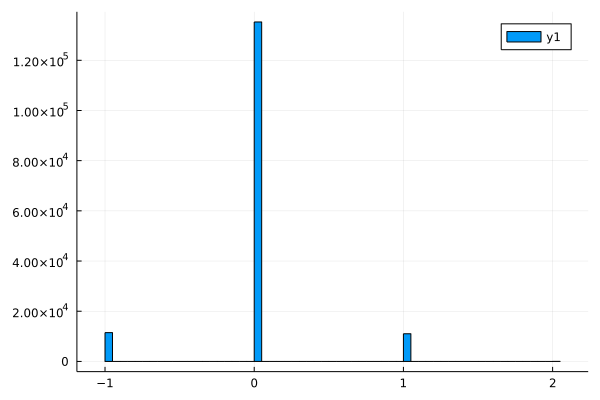

In [14]:
histogram(cns_pred .- cns_true)

### Final optimization
- Maximize transmission (< 95%)
- Output energy should be 70 KeV (0.070 MeV)
- Minimize RFQ length
- Minimize longitudinal emittance
- Minimize transverse emittance

In [15]:
# how to go from scaled vec to unscaled
recorr(minmaxscale([1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]; var="x", inverse=true))

14-element Vector{Any}:
  11.99997329711914
   5.0004377365112305
 159.9991330230912
   1.6999975442886353
   1.8499996289507852
 499.9979407787323
 499.99658024311066
 -30.000564575195312
 -25.000076309743637
 499.99833953380585
 499.99743032455444
   1.9999994572613884
 -20.000009662052673
   0.07499995827674866

In [35]:
function objective3(x_vec)
    x_vec_unscaled = recorr(minmaxscale(x_vec; var="x", inverse=true))
    x_vec_unscaled_dict = Dict("DVAR$i" => x_vec_unscaled[i] for i in 1:14)
    local cellnumber
    try
        cellnumber = compute_cellnumber(jl_row_to_py_row(x_vec_unscaled_dict))
    catch
        cellnumber = 0
    end
    y = predict((x_vec..., cellnumber % 2))
    target_energy_scaled = transform(y_scalers["OBJ2"], 0.070)[1]
    [-y[1], (y[3] - target_energy_scaled)^2, y[2], y[4], y[5], y[6]]
end

objective3 (generic function with 1 method)

In [36]:
x3s = [sample for sample in initial_samples];
x3s = unique(x3s)
y3s = objective3.(x3s);

In [37]:
if length(x3s) != length(unique(x3s))
    print("Duplicate entries in x3")
end
if length(x3s) != length(y3s)
    print("Dimension mismatch between x3 and y")
end
radial_basis_ego_3 = RadialBasis(x3s, y3s, repeat([-1.], 14), repeat([1.], 14))

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [38]:
pareto_set_3, pareto_front_3 = surrogate_optimize(
    objective3, SMB(), repeat([-1.], 14), repeat([1.], 14), radial_basis_ego_3, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [39]:
obj1_3 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front_3];
dE_3 = [item[2] for item in pareto_front_3];
obj3_3 = [inverse_transform(y_scalers["OBJ3"], item[3])[1] for item in pareto_front_3];
obj4_3 = [inverse_transform(y_scalers["OBJ4"], item[4])[1] for item in pareto_front_3];
obj5_3 = [inverse_transform(y_scalers["OBJ5"], item[5])[1] for item in pareto_front_3];
obj6_3 = [inverse_transform(y_scalers["OBJ6"], item[6])[1] for item in pareto_front_3];

unscaled_pareto_front_3 = [obj1_3, dE_3, obj3_3, obj4_3, obj5_3, obj6_3]

6-element Vector{Vector{Float64}}:
 [92.28625149553217, 63.90773682744614, 95.19393984533562, 96.00102484509253, 78.4978539172133, 63.394496973980736, 74.94593354046272, 68.05961954809125, 60.872767173945284, 55.3394018453445  …  61.065775508724975, 59.3101595077103, 54.6979788949679, 56.03889236477673, 58.78987736426703, 56.790610503053074, 66.58197146271576, 62.148034733021134, 59.15239198379211, 71.8904954144293]
 [0.0016270730876085568, 0.36109011353551385, 0.19323111036795917, 0.013120751959156607, 0.03465174747977219, 0.2876145234436721, 0.6256814286619892, 0.08435148844171023, 0.0005787773877074632, 0.02711707546508105  …  0.042888000659902156, 8.671028188870265e-5, 0.07569897761713973, 0.1455657794706254, 0.0905070253499707, 0.26055324787166, 0.01429924164618228, 0.027318391909239705, 0.009079168539566229, 0.4717996516796696]
 [165.8909526813244, 50.74453271395078, 146.92352058112039, 172.08409253607593, 140.67461574662906, 171.82940909723587, 130.3671118494952, 131.51594172729

In [40]:
emit_cutoff = 0.04
long_emit_mask = obj4_3 .< emit_cutoff; trans_emit_mask = obj5_3 .< emit_cutoff;


transmission_cutoff = 90
high_transmission_mask = obj1_3 .> 90

sum(long_emit_mask .& trans_emit_mask .& high_transmission_mask)

9

In [41]:
candidates = [i for i in 1:length(obj1_3)][long_emit_mask .& trans_emit_mask .& high_transmission_mask]

9-element Vector{Int64}:
 124
 196
 209
 295
 370
 372
 374
 483
 518

In [42]:
test_x_transformed = minmaxscale(
    decorr([
        11.312972997315228, 103.74379149079323, 149.3844627470438,
        1.4468421232886612, 1.5137411917386079, 140.85678020119667,
        473.1951289474964, -50.19836366921663, -43.642034931217914,
        245.1396713256836, 245.14222234487534, 1.8956206666091737,
        -37.693693497970166, 0.06037112592457561,
    ]);
    var="x"
)

println(predict((test_x_transformed..., 0.)))
println(predict((test_x_transformed..., 1.)))

[0.7679930472923572 0.3380752670733307 -0.45640557252933145 -0.8362856137674357 -0.7435289543839798 -0.7734108778689787]
[0.7866750186403212 0.3188235154034012 -0.4554849642937827 -0.826415742873267 -0.8345830277685841 -0.6575148567804928]


In [43]:
for j in candidates
    println("candidate $j")
    candidate_dvars = minmaxscale(pareto_set_3[j]; var="x", inverse=true)
    println(recorr(candidate_dvars))
    for i in 1:6
        println("OBJ$i: ", unscaled_pareto_front_3[i][j])
    end
    println(" ")
end

candidate 124
Any[11.312972997315228, 103.74379149079323, 149.3844627470438, 1.4468421232886612, 1.5137411917386079, 140.85678020119667, 473.1951289474964, -50.19836366921663, -43.642034931217914, 245.1396713256836, 245.14222234487534, 1.8956206666091737, -37.693693497970166, 0.06037112592457561]
OBJ1: 95.28683161814637
OBJ2: 0.18300653169459666
OBJ3: 192.83471250216132
OBJ4: 0.03855834786956841
OBJ5: 0.024661802831386033
OBJ6: 0.03333013285786453
 
candidate 196
Any[9.146016827784479, 64.984718054533, 76.2309538327026, 1.505210397299379, 1.790983624151413, 159.37423488497734, 287.04686722159386, -49.37874283641577, -44.208072484098636, 446.882479429245, 415.69542080163956, 1.9007704867739823, -38.63378069219178, 0.07181638060865225]
OBJ1: 95.67267228227433
OBJ2: 0.06648355624738939
OBJ3: 148.78471286788186
OBJ4: 0.035213998773137536
OBJ5: 0.026648062984838503
OBJ6: 0.025160884000038373
 
candidate 209
Any[9.638196147046983, 92.40610334277153, 132.9467256531183, 1.3640406182967126, 1.5

Clearly, `138` is the winner.

In [44]:
candidate_dvars[[1, 2, 3]]

LoadError: UndefVarError: candidate_dvars not defined

In [45]:
function plot_pairwise_scatter(vec1, vec2, vec1label, vec2label, indexes, winner_index, incl_xticks, incl_yticks)
    loser_indexes = [i for i in indexes if i != winner_index]
    
    
    scatter(
        [vec1[i] for i in loser_indexes], [vec2[i] for i in loser_indexes];
        xlabel=vec1label, ylabel=vec2label, legend=false, markersize=3, markerstrokewidth=0.5,
        xformatter = incl_xticks ? :auto : Returns(""), yformatter = incl_yticks ? :auto : Returns("") 
    )
    
    scatter!([vec1[winner_index]], [vec2[winner_index]]; markershape=:star5, markersize=10, markerstrokewidth=0.5)
end

plot_pairwise_scatter (generic function with 1 method)

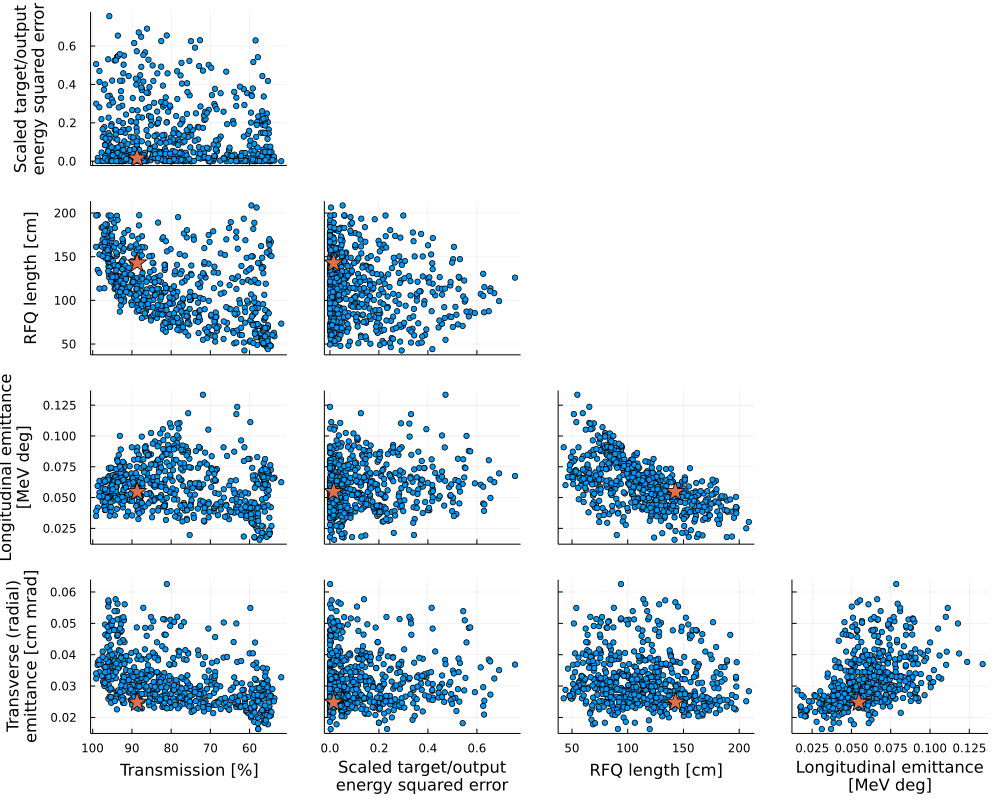

In [46]:
labels = [
    "Transmission [%]",
    "Scaled target/output\nenergy squared error",
    "RFQ length [cm]",
    "Longitudinal emittance\n[MeV deg]",
    "Transverse (radial)\nemittance [cm mrad]"
]
indexes = [i for i in 1:length(pareto_front_3)]

layout = @layout([ ° _ _ _ ; ° ° _ _ ; ° ° ° _ ; ° ° ° ° ])

#plot(p1, p2, p3, layout = l)

plots_dict = Dict()

for i in 1:5
    for j in 1:5
        if i < j
            p = plot_pairwise_scatter(
                unscaled_pareto_front_3[i], unscaled_pareto_front_3[j],
                j==5 ? labels[i] : "", i==1 ? labels[j] : "", indexes, 138, j==5, i==1
            )
            if i == 1
                xflip!(true)
            end
            # display(p)
            merge!(plots_dict, Dict("$i$j"=>p))
        end
    end
end

pareto_plot = plot(
    [plots_dict["$i$j"] for j in 1:5 for i in 1:5 if i<j]...,
    layout = layout, widths=(1/4,1/4,1/4,1/4), size=(1000,800), dpi=500
)

# savefig(pareto_plot,"../../img/pareto_plot.png")

## CHECKING OPTIMAL ANSWER FROM ABOVE

In [47]:
optimal_dvars = [
    9.14601474441588,
    64.9847204387188,
    76.2309561819387,
    1.5052128004608676,
    1.7909850165139312,
    159.3742377460003,
    287.0468702018261,
    -49.37874272093177,
    -44.20807974211494,
    446.882483959198,
    415.69541972875595,
    1.9007708828235987,
    -38.63379833969139,
    0.07181640870840056,
]

optimal_dvars_decorr = decorr(optimal_dvars);
optimal_dvars_decorred_scaled = minmaxscale(optimal_dvars_decorr);
optimal_predicted_objs_scaled = predict(optimal_dvars_decorred_scaled..., compute_cellnumber);
optimal_predicted_objs = minmaxscale(optimal_predicted_objs_scaled; var="y", inverse=true)

LoadError: DimensionMismatch: matrix A has dimensions (100,15), vector B has length 14